# Semi-supervised anomaly detection: log mel-spectrogram - model 2

This notebook will show to implement in Tensorflow the AE model described in the paper [MIMII Dataset: Sound Dataset for
Malfunctioning Industrial Machine Investigation and Inspection](https://www.arxiv-vanity.com/papers/1909.09347/)

## Libraries

Let's load the libraries for this notebook.
- **Tensorflow dataset** to load the dataset
- **Tensorflow** to create an AE model
- **Pandas** to manipulate results
- **Sklearn** to compute metrics
- **Plotnine** to plot results

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tensorflow.keras.layers import (
    InputLayer,
    Dense,
)

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import pandas as pd

import sklearn
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    roc_auc_score
)

import plotnine as p9

import datetime

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
print(f"Tensorflow datasets: {tfds.__version__}")
print(f"Tensorflow: {tf.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"Plotnine: {p9.__version__}")

Tensorflow datasets: 4.3.0
Tensorflow: 2.4.1
Sklearn: 0.24.2
Numpy: 1.19.5
Pandas: 1.2.4
Plotnine: 0.8.0


Let's set the seed for the Tensorflow dataset.

In [3]:
config = tfds.ReadConfig(try_autocache=True, shuffle_seed=42)

## Dataset

Let's load the dataset and create three sets (train, validation, test). We make the train set (90%) and validation set (10%) from the train data and the test set from the test data. 

In [4]:
import pump
data_dir = "../dataset"

(train, val, test), info = tfds.load(
    "pump",
    split=["train[:90%]", "train[90%:]", "test"],
    data_dir=data_dir,
    with_info=True,
    shuffle_files=True,
    read_config=config,
)

## Feature extraction

We will use 64 log mel-band energies from a spectrogram with an analysis frame of 64 ms and 50% hop size. 

In [5]:
A = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=64, num_spectrogram_bins=512+1, sample_rate=16_000, dtype=tf.float32
)

In [6]:
def mel(item):
    audio = tf.cast(item["audio"], tf.float32)
    audio = audio / 2**15

    # Calculate the STFT of the audio signal
    stfts = tf.signal.stft(
            audio,
            frame_length=1024,
            frame_step=512,
            pad_end=False,  # librosa test compatibility
        )
    # Get Magnitude fo the STFT
    mag_stfts = tf.abs(stfts)

    # Get the mel-spectrogram
    melgrams = tf.tensordot(
            tf.square(mag_stfts), A, axes=1
    )

    # Change of base for logarithmics: from natural logarithmic to common logarithmic 
    def _tf_log10(x):
        numerator = tf.math.log(x)
        denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator

    # Calculate the log-mel spectrogram    
    log_melgrams = 20 / 2 * _tf_log10(melgrams + 10e-6)

    # Concat 5 time frames together to feed the model
    concat_melgrams = tf.concat(
        [
            tf.roll(log_melgrams, shift=1, axis=0),
            tf.roll(log_melgrams, shift=2, axis=0),
            log_melgrams,
            tf.roll(log_melgrams, shift=-1, axis=0),
            tf.roll(log_melgrams, shift=-2, axis=0)
        ],
        axis=1,
    )
    concat_melgrams = concat_melgrams[2:-2,:]

    item["audio"] = concat_melgrams
    return item

Let's prepare the sets for training. AE models need that the input and the output be the same.

In [7]:
def prep_train(item):
    return item["audio"], item["audio"]

In [8]:
BATCH_SIZE = 512
SHUFFLE_BUFFER_SIZE = 1024

train = train.map(mel)
train2 = train.map(prep_train).batch(BATCH_SIZE)

val = train.map(mel)
val2 = train.map(prep_train).batch(BATCH_SIZE)

test = test.map(mel)
test2 = test.batch(BATCH_SIZE)

## Training

This is the AE model described in the paper [MIMII Dataset: Sound Dataset for
Malfunctioning Industrial Machine Investigation and Inspection](https://www.arxiv-vanity.com/papers/1909.09347/)

In [9]:
autoencoder = Sequential(
    [
        InputLayer(input_shape=(307, 320)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(8, activation='relu'),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(320, activation=None)
    ]
)

In [10]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 307, 64)           20544     
_________________________________________________________________
dense_1 (Dense)              (None, 307, 64)           4160      
_________________________________________________________________
dense_2 (Dense)              (None, 307, 8)            520       
_________________________________________________________________
dense_3 (Dense)              (None, 307, 64)           576       
_________________________________________________________________
dense_4 (Dense)              (None, 307, 64)           4160      
_________________________________________________________________
dense_5 (Dense)              (None, 307, 320)          20800     
Total params: 50,760
Trainable params: 50,760
Non-trainable params: 0
____________________________________________________

We use same parameters as the paper.

In [11]:
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())

Let's create a Tensorboard callback to check the results in Tensorboard and a ModelCheckpoint callback to save the best model.

In [12]:
log_dir = os.path.join('..', 'logs', 'semi-mel2', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir, update_freq=1, histogram_freq=1, write_graph=True
)

In [13]:
checkpoint_filepath = os.path.join("tmp", "semi-mel2", "checkpoint")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [14]:
history = autoencoder.fit(
    train2,
    epochs=50,
    shuffle=True,
    validation_data=val2,
    callbacks=[tb_callback, model_checkpoint_callback],
    verbose=1,
)

Epoch 1/50
6/6 [==============================] - 158s 29s/step - loss: 131.6253 - val_loss: 116.9478
Epoch 2/50
6/6 [==============================] - 159s 29s/step - loss: 109.6556 - val_loss: 83.0146
Epoch 3/50
6/6 [==============================] - 157s 29s/step - loss: 75.2256 - val_loss: 51.3200
Epoch 4/50
6/6 [==============================] - 155s 28s/step - loss: 45.9704 - val_loss: 31.7235
Epoch 5/50
6/6 [==============================] - 156s 28s/step - loss: 29.1095 - val_loss: 22.9366
Epoch 6/50
6/6 [==============================] - 156s 29s/step - loss: 21.8481 - val_loss: 19.4684
Epoch 7/50
6/6 [==============================] - 157s 29s/step - loss: 18.9459 - val_loss: 17.9887
Epoch 8/50
6/6 [==============================] - 156s 29s/step - loss: 17.8988 - val_loss: 17.3321
Epoch 9/50
6/6 [==============================] - 156s 29s/step - loss: 17.1063 - val_loss: 16.9841
Epoch 10/50
6/6 [==============================] - 156s 29s/step - loss: 16.7615 - val_loss: 16.8

## Testing

Let's join train and test set together for faster predictions.

In [15]:
audios = train.concatenate(test)

In [16]:
pred = autoencoder.predict(audios.map(lambda item: item["audio"]).batch(BATCH_SIZE))

Let's compute the reconstruction error for all audios.

In [17]:
error_lst = []
for item, pred in zip(tfds.as_numpy(audios), pred):
    error = np.mean(np.square(item["audio"] - pred))
    error_lst.append(error)

To check how the model behaves, we can tranform the Tensorflow dataset into a dataframe and add the previous computed reconstruction error to it.

In [18]:
audios_df = tfds.as_dataframe(audios, info)

# Convert byte-type texts to string-type texts
for col in audios_df:
    if isinstance(audios_df[col][0], bytes):
        audios_df[col] = audios_df[col].str.decode("utf8")

dct_columns = {
    "audio/id": "id", 
    "audio/machine": "machine_id", 
    "audio/split": "split",
}

# Convert object-type columns to a more convenient data type
dct_types = {
    "id": "string",
    "machine_id": "category",
    "split": "category",
    "label": "category",
}

audios_df = (
    audios_df
    .rename(columns=dct_columns)
    .astype(dct_types)
)

audios_df["split"] = audios_df["split"].cat.rename_categories({0: "train", 1: "test"})
audios_df["label"] = audios_df["label"].cat.rename_categories({0: "normal", 1: "anomaly"})

audios_df.sample(5)

,audio,id,machine_id,split,label
2477,"[[-2.7875395, 1.6016552, -6.4621453, -5.028084...",0192,00,train,normal
1790,"[[-4.411544, -6.801692, -4.9843354, -5.578091,...",0027,00,train,normal
847,"[[-7.286358, -0.038434725, -1.4054885, -3.7830...",0572,02,train,normal
910,"[[-8.980205, -1.3517476, -1.8648397, 1.4344592...",0489,04,train,normal
304,"[[0.2650661, 0.10619744, 1.789721, -6.756939, ...",0835,06,train,normal


In [19]:
audios_df["error"] = error_lst

In [20]:
audios_df.sample(5)

,audio,id,machine_id,split,label,error
1430,"[[-0.68483007, 0.81773925, 1.2178646, -0.00749...",0325,06,train,normal,13.578239
1665,"[[0.33393234, -2.5177956, -5.673082, -5.216605...",0526,04,train,normal,41.273838
2826,"[[0.24224415, -0.38163954, -7.695062, -12.0245...",0356,04,train,normal,21.630625
3433,"[[-4.3812113, 0.63253725, 2.549387, 0.57952595...",0070,04,test,anomaly,28.914246
3722,"[[-6.234923, 1.0997583, 0.201184, 1.6336286, -...",0068,04,test,normal,61.475533


Let's compute the mean and the standard deviation of the reconstruction error of the train set.

In [21]:
(
    audios_df
    .query("split == 'train'")
    .groupby("machine_id")
    .agg({"error": ["mean", "std"]})
)

error           
                 mean        std
machine_id                      
00          26.651006  13.876286
02          27.280892  15.340480
04          26.247069  13.974535
06          26.572646  14.895569

Let's compute the mean and the standard deviation of the reconstruction error of the test set.

In [22]:
(
    audios_df
    .query("split == 'test'")
    .groupby(["label", "machine_id"])
    .agg({"error": ["mean", "std"]})
)

error           
                         mean        std
label   machine_id                      
normal  00          34.871846  22.538611
        02          31.767972  16.968680
        04          32.670067  15.326876
        06          36.446039  24.027785
anomaly 00          37.357290  23.681935
        02          35.827076  25.128134
        04          32.519774  19.392254
        06          31.502627  16.016001

It seems this model can't distinguish anomaly sound from normal sounds very well.

Let's plot the a histogram of the construction error per machine to see more clear.

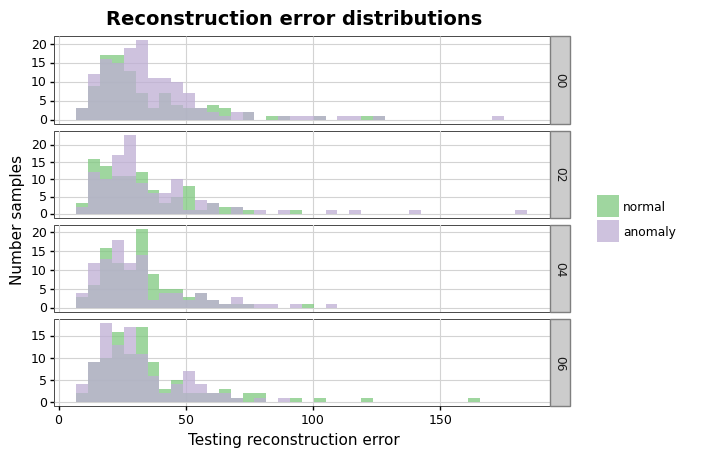

In [23]:
p = (
    p9.ggplot(audios_df.query("split == 'test'"), p9.aes(x="error", fill="label"))
    + p9.geom_histogram(
        p9.aes(y="stat(count)"), position="identity", alpha=0.75
    )
    + p9.scale_x_continuous(name="Testing reconstruction error")
    + p9.scale_y_continuous(name="Number samples")
    + p9.labs(
        title="Reconstruction error distributions",
    )
    + p9.scale_fill_brewer(type="qualitative", palette="Accent") 
    + p9.facet_grid("machine_id ~ .", scales="free")
    + p9.theme_bw()
    + p9.theme(
        panel_border=p9.element_rect(colour="black", fill=None, size=0.5),
        axis_text_x=p9.element_text(colour="black", size=9),
        axis_text_y=p9.element_text(colour="black", size=9),
        legend_key=p9.element_blank(),
        legend_title=p9.element_blank(),
        panel_grid_major=p9.element_line(colour="#d3d3d3"),
        panel_grid_minor=p9.element_blank(),
        panel_background=p9.element_blank(),
        plot_title=p9.element_text(size=14, family="Tahoma", face="bold"),
        text=p9.element_text(family="Tahoma"),
    )
)

print(p)

Histograms show more clear that the model can't differentiate anomaly audios from normal audio very well.

This [AWS](https://aws.amazon.com/es/blogs/machine-learning/performing-anomaly-detection-on-industrial-equipment-using-audio-signals/) post shows how the histogram from a good model should look like.

![Better model](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2020/12/22/ML-1479-4.jpg)

## Metrics

Let's see how bad our model is. To distinguish anomaly audios from normal audios, we set the threshold one standard deviation above the mean of the train set. 

In [24]:
avg = (
    audios_df
    .query("split == 'train'")
    ["error"]
    .mean()
)

std = (
    audios_df
    .query("split == 'train'")
    ["error"]
    .std()
)

threshold = avg + std

In [25]:
print(threshold)

41.30918907813345


Let's create a new column with the predicted label based on the threshold.

In [26]:
audios_df["label_pred"] = audios_df["error"] > threshold

In [27]:
audios_df.head()

,audio,id,machine_id,split,label,error,label_pred
0,"[[4.3435826, -1.4703677, -6.8795943, -5.232863...",0784,06,train,normal,20.192614,False
1,"[[-4.171905, -7.304402, -6.1516943, -0.3673963...",0215,02,train,normal,66.811012,True
2,"[[-3.672999, -4.516965, 1.8487122, 1.7680111, ...",0918,06,train,normal,16.891802,False
3,"[[-1.0986718, -0.51198477, 1.760179, -8.916344...",0033,06,train,normal,22.767317,False
4,"[[-4.7961698, 1.6355705, -0.73018026, -3.11030...",0580,02,train,normal,25.093842,False


Let's show the precision, recall, f1-score and roc-auc score for the four machines.

In [28]:
audios_df["label"] = audios_df["label"].cat.rename_categories({"normal": 0, "anomaly": 1})

### Machine_id=00

In [29]:
machine_id = "00"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.42      0.73      0.54       100
           1       0.62      0.31      0.41       143

    accuracy                           0.48       243
   macro avg       0.52      0.52      0.47       243
weighted avg       0.54      0.48      0.46       243



In [30]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[73 27]
 [99 44]]


In [31]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5188


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=02

In [32]:
machine_id = "02"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.48      0.74      0.58       100
           1       0.54      0.28      0.37       111

    accuracy                           0.50       211
   macro avg       0.51      0.51      0.48       211
weighted avg       0.51      0.50      0.47       211



In [33]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[74 26]
 [80 31]]


In [34]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5096


This model is slightly better distinguishing sounds for this machine that tossing a coin. 

### Machine_id=04

In [35]:
machine_id = "04"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.51      0.78      0.62       100
           1       0.53      0.25      0.34       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.48       200
weighted avg       0.52      0.52      0.48       200



In [36]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[78 22]
 [75 25]]


In [37]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.5150


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

### Machine_id=06

In [38]:
machine_id = "06"
temp = (
    audios_df
    .query("machine_id == @machine_id and split == 'test'")
)  
print(classification_report(temp["label"], temp["label_pred"]))

              precision    recall  f1-score   support

           0       0.48      0.74      0.58       100
           1       0.47      0.23      0.30       102

    accuracy                           0.48       202
   macro avg       0.48      0.48      0.44       202
weighted avg       0.48      0.48      0.44       202



In [39]:
print(confusion_matrix(temp["label"], temp["label_pred"]))

[[74 26]
 [79 23]]


In [40]:
score = roc_auc_score(temp["label"], temp["label_pred"])
print(f"ROC-AUC score: {score:.4f}")

ROC-AUC score: 0.4827


This model is so bad distinguishing sounds for this machine that tossing a coin can predict better. 

## Conclusions

Although we tried to copy the model of the paper, metrics are worse.